In [12]:
import sys
import os

module_path = os.path.abspath(os.path.join('../'))
sys.path.insert(0, module_path)

import pandas as pd
import seaborn as sns 

from pathlib import Path
import json

import katspace
import katspace.core
import katspace.data
import katspace.plot

import importlib
for mod in ["katspace.core", "katspace.data", "katspace.plot"]:
    importlib.reload(sys.modules[mod])

from katspace.core import DATA_DIR, DRIVE_DIR, SPACE_TYPES, RESULTS_DIR
from katspace.data import chunker, chunk_lengths
from katspace.plot import hist_heatmap as plot_hist_heatmap

import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import numpy as np
import math

RESULTS_DIR_CANON = Path(RESULTS_DIR, "predict-286-canon")

In [2]:
def sum_results(labels):
  counter = Counter(labels)
  return counter

def results_from_json_old(filename, results_dir = RESULTS_DIR_CANON):
    json_file_path = Path(results_dir, Path(filename).stem + '-result.json')

    if json_file_path.exists():
        with open(json_file_path, 'r', encoding="utf-8") as f:
            json_results = json.load(f)
        return json_results
    else:
        return None

#copied to data.py
def results_from_json(filenames, results_dir = RESULTS_DIR_CANON): 

  if isinstance(filenames, str):
    filename = filenames
    json_file_path = Path(results_dir, Path(filename).stem + '-result.json')

    if json_file_path.exists():
        with open(json_file_path, 'r', encoding="utf-8") as f:
            json_results = json.load(f)
        return json_results
    else:
        return None
  elif isinstance(filenames, list):
    return {filename : results_from_json(filename) for filename in filenames}

def results_into_df(df  : pd.DataFrame, results_dir = None) -> pd.DataFrame :
  
  #filenames = df["Filename"]
  corpus_sel = df

  for space_type in SPACE_TYPES:
    corpus_sel.loc[:,space_type] = [0]*corpus_sel.shape[0]

  for index, row in tqdm(corpus_sel.iterrows()):
    filename = row["filename"]
    results = results_from_json(filename, results_dir = results_dir) 
    if results is not None:
      #print(results[0])
      labels = [result["label"] for result in results]
      result = sum_results(labels)
      for space_type in SPACE_TYPES:
        corpus_sel.loc[index, space_type] = result[space_type]
  return corpus_sel

def prepare_plot_from_json(corpus_sel : pd.DataFrame):
  grouped_data = corpus_sel.groupby("year")["filename"]
  years = []
  space_types_dict = {space_type : [] for space_type in SPACE_TYPES}
  space_types_dict["total"] = []
  space_types_dict["all_space"] = []

  for year, seq in grouped_data:
      year_fn = seq.unique()
      #print(year)
      results = []
      for filename in year_fn:
          json_result = results_from_json(filename)
          if json_result is not None:
              results += json_result
      labels = [result["label"] for result in results]
      space_labels = [result["label"] for result in results if result["label"] != 'no_space']
      year_sum = sum_results(labels)
      space_year_sum = sum_results(space_labels)
      #print(year_sum)
      years.append(year)
      for space_type in SPACE_TYPES:
          space_types_dict[space_type].append(year_sum[space_type])

      space_types_dict["total"].append(year_sum.total())
      space_types_dict["all_space"].append(space_year_sum.total())
  return years, space_types_dict

def prepare_plot_from_df(corpus_sel : pd.DataFrame):
  corpus_sel = corpus_sel[corpus_sel["total"] > 0]
  cols = ["year"] + list(SPACE_TYPES)
  summed_data = corpus_sel[cols].groupby("year").sum().loc[:,SPACE_TYPES]

  space_types_dict = {space_type : [] for space_type in SPACE_TYPES}
  space_types_dict["total"] = []
  space_types_dict["all_space"] = []

  summed_data["total"] = sum([summed_data[space_type] for space_type in SPACE_TYPES])
  summed_data["all_space"]  = sum([summed_data[space_type] for space_type in SPACE_TYPES if space_type != "no_space"])

  years = summed_data.index.astype(float)
  for space_type in summed_data:
    space_types_dict[space_type] = summed_data[space_type]

  return years, space_types_dict

def round_to_decade(y):
  return int(10 * math.floor(y / 10))

def prepare_plot_from_df_w_sums(corpus_sel : pd.DataFrame, smooth_to_next_decade = False):
  cols = ["year"] + list(SPACE_TYPES) + ["all_space", "total"]
  if smooth_to_next_decade:
    


    corpus_sel["year"] = corpus_sel["year"].apply(round_to_decade)

  summed_data = corpus_sel[cols].groupby("year").sum()

  space_types_dict = {space_type :  summed_data[space_type] for space_type in list(SPACE_TYPES) + ["all_space", "total"]}

  years = summed_data.index.astype(float)
     
  return years, space_types_dict


def plot_narrative_time(results, chunksize = 50, space_types = ("perceived_space", "action_space", "visual_space", "descriptive_space"),
                        total = False, sum_sel = ("perceived_space", "action_space", "visual_space", "descriptive_space")):
  def chunker(seq, size):
    return [seq[pos:pos + size] for pos in range(0, len(seq), size)]


  def total_sum(counter, sum_sel):
    num = [counter[space_type] for space_type in sum_sel]
    return sum(num)

  labels = [result["label"] for result in results]
  chunks = chunker(labels, chunksize)
  num_chunks = len(chunks)
  


  counters = [Counter(chunk) for chunk in chunks]
  # change order of indexing to have space type as outermost index
  count_dict = {space_type : [counter[space_type] for counter in counters] for space_type in space_types}
  count_dict["all_space"] = [total_sum(counter, sum_sel) for counter in counters]

  fig, ax = plt.subplots()
  x = [chunk[0] for chunk in chunker(range(len(labels)), chunksize)]

  for space_type in space_types:
    y = np.array(count_dict[space_type]) / np.array([chunksize]*num_chunks)

    label = space_type

    ax.plot(x, y, label = label)

  if total:
    y = np.array(count_dict["all_space"]) / np.array([chunksize]*num_chunks)

    label = "all_space"
    ax.plot(x, y, label = label)

  ax.legend()
  ax.set_xlabel("Sentences")
  ax.set_ylabel("% Types of setting")
  plt.show()

def plot_history(years, space_types_dict, normalize = True, total_space = False, cumul = False, plot_no_space = False, smooth_to_next_decade = False):
  fig, ax = plt.subplots(figsize=(10, 6))
  
  y_dict = {}
  types_for_plot = list(SPACE_TYPES)

  if total_space:
     types_for_plot = types_for_plot + ["all_space"]

  for space_type in types_for_plot:
    if (not plot_no_space) and space_type == 'no_space':
      continue
    if normalize: 
      y_dict[space_type] = np.array(space_types_dict[space_type]) / np.array(space_types_dict["total"])
    elif not normalize: 
      y_dict[space_type] = np.array(space_types_dict[space_type])

  if smooth_to_next_decade:
     delta_year = 10
  else:
     delta_year = 15
  ticks = [ year for year in years if year%delta_year==0]
  labels = map(str,map(round,ticks))

  for space_type in y_dict.keys():
    label = space_type
    ax.plot(years, y_dict[space_type], label=label)

  ax.legend()
  ax.set_xlabel("Year")
  ax.set_ylabel("Frequency")
  ax.set_xticks(ticks, labels=labels, rotation=90)

  return fig, ax


def plot_preprocess(results, num_chunks=20, sum_sel=("perceived_space", "action_space", "visual_space", "descriptive_space"), results_format = "parquet"):
    #ignore files without results
    results = {filename: result for filename, result  in results.items() if result != None}

    #ignore files with fewer than num_chunks sentences
    results = {filename: result for filename, result  in results.items() if len(result) >= num_chunks}

    print(f"Ignoring {len([filename for filename, result  in results.items() if len(result) < num_chunks])} files because they have too few sents")

    if results_format != "parquet":
      labels = {filename: [result["label"] for result in results[filename]] for filename in results.keys()}
    else:
      labels = results

    chunked_labels = {filename: chunker(labels[filename], num_chunks=num_chunks) for filename in labels.keys()}
    chunk_sizes = {filename: [len(chunk) for chunk in chunked_labels[filename]] for filename in labels.keys()}
    chunk_size_zero = [filename for filename in labels.keys() if chunk_sizes[filename] == 0]
    if len(chunk_size_zero) > 0:
      print(f"The followowing files have chunks of size 0: \n {chunk_size_zero}")

    counters = {filename: [Counter(label_chunk) for label_chunk in chunked_labels[filename]] for filename in chunked_labels.keys()}

    def total_sum(counter, sum_sel):
        num = [counter[space_type] for space_type in sum_sel]
        return sum(num)

    # change order of indexing to have space type as outermost index
    count_dict = {space_type: {filename: [counter[space_type] for counter in counters[filename]] for filename in counters.keys()} for space_type in SPACE_TYPES}

    count_dict["all_space"] = {}
    for filename in counters.keys():
      count_dict["all_space"][filename] = [total_sum(counter, sum_sel) for counter in counters[filename]]

    return count_dict, chunk_sizes

def plot_hist(count_dict, chunk_sizes, title = "", fig = None, ax = None, bins = [20, 20], **kwargs):

    num_chunks = bins[0]

    x,y = plot_hist_preprocess(count_dict, chunk_sizes, num_chunks = num_chunks, debug_msg = title)
    ax.set_title(title)
    ax.set_xlabel("Narrative section")
    ax.set_ylabel("Frequency")
    ax.hist2d(x, y, bins = bins, **kwargs)

def plot_violin(count_dict, chunk_sizes, num_chunks, title = "", fig = None, ax = None, **kwargs):
    
    data = [[count_dict[filename][col] / chunk_sizes[filename][col] for filename in count_dict.keys()] for col in range(0, num_chunks)]
    pos = range(0, num_chunks)
    ax.violinplot(data, pos, points=100, widths=0.3,
                     showmeans=True, showextrema=True, showmedians=True)
    ax.set_title(title)

def plot_hist_preprocess(count_dict, chunk_sizes, num_chunks = 20, debug_msg = ""):

    y = []
    x = []

    for filename in count_dict.keys():
        for c, size in enumerate(chunk_sizes[filename]):
          if size == 0:
            print(f"chunk nr {c} has size zero: {filename}")
            #zero_chunks.append((filename, c))
        norm_counts_np = np.array(count_dict[filename]) / np.array(chunk_sizes[filename])
        y += list(norm_counts_np)
        x += range(1, num_chunks + 1)
        if len(x) != len(y):
          print(f"x and y have different lengths: {filename}, {debug_msg} \n ++++++ x: {x}, \n ++++++ y: {y}")
          break
    return x,y
    
def plot_narrative_time_stats(results, num_chunks=20, plot_type = "histogram", space_types=("perceived_space", "action_space", "visual_space", "descriptive_space", "no_space"),
                                total=False, sum_sel=("perceived_space", "action_space", "visual_space", "descriptive_space")):

    count_dict, chunk_sizes = plot_preprocess(results, num_chunks, sum_sel)
    vert_num_chunks = 20

    if total == True:
      space_types = list(space_types) + ["all_space"]

    if plot_type == "histogram":
      color = {"perceived_space": "Blues",
                "action_space": "Greens",
                "visual_space": "Reds",
                "descriptive_space": "GnBu",
                "no_space": "Greys",
                "all_space": 'Purples'
                }
      fig, axs = plt.subplots(ncols=1, nrows=len(space_types), figsize=(3, len(space_types) * 3),
                        layout="constrained") 

      for i, space_type in enumerate(space_types):
        plot_hist(count_dict[space_type], chunk_sizes, title = space_type, fig = fig, ax = axs[i], bins = [num_chunks, vert_num_chunks], cmap = color[space_type])

    elif plot_type == "violin":     
      fig, axs = plt.subplots(ncols=1, nrows=len(space_types), figsize=(10, len(space_types) * 6),
                        layout="constrained")
     # pos = range(1, num_chunks + 1)
      for i, space_type in enumerate(space_types):
        plot_violin(count_dict[space_type], chunk_sizes, num_chunks, title = space_type, fig = fig, ax = axs[i])
    
    elif plot_type == "contour":
      pass
    plt.show()

def plot_history_violin(results_df, num_chunks): 
    num_chunks = 2
    chunk_sizes = {"fn1" : [1,1]}
                  
                  
    count_dict = {"test_space" : {"fn1" : [0,1]}, 
                  "test_space2" : {"fn1" : [0,1]}
                  }
    space_types = count_dict.keys()
    fig, axs = plt.subplots(ncols=1, nrows=len(space_types), figsize=(10, len(space_types) * 6),
                        layout="constrained")
    # pos = range(1, num_chunks + 1)
    for i, space_type in enumerate(space_types):
      plot_violin(count_dict[space_type], chunk_sizes, num_chunks, title = space_type, fig = fig, ax = axs[i])

In [ ]:
#load canon df, get filenames

canon_df = pd.read_excel(Path(DATA_DIR, "20240818_canon_master_merged.xlsx", index = 0))
filenames = canon_df["filename"]
filenames = list(filenames)
filenames

In [4]:
from katspace.core import space_types_pos, space_types_ext


def calculate_ratios(df, insert_values=False, set_index=True, suffix="_rt"): 
    if not insert_values:
        _df = df.copy()
    else:
        _df = df

    _df['all_space'] = _df[space_types_pos].sum(axis=1)

    for space_type in space_types_ext:
        _df[space_type + suffix] = _df[space_type] / _df["total"]


    if not insert_values:
        _df = _df[["year", "author_last", "title"] + [space_type + suffix for space_type in space_types_ext]]
    
    if set_index:
        _df.set_index("year", inplace=True)
    
    return _df


## Plot outliers in Canon Corpus

In [6]:
sel = (canon_df["year"] > 1780)
plot_df = katspace.plot.calculate_ratios(canon_df[sel])
#plot_df = plot_df[plot_df["action_space_rt"] < 0.30]
plot_df

,perceived_space_rt,action_space_rt,visual_space_rt,descriptive_space_rt,no_space_rt,all_space_rt
year,,,,,,
1842,0.089396,0.087984,0.009701,0.016332,0.796586,0.203414
1852,0.057500,0.087654,0.009182,0.012591,0.833073,0.166927
1840,0.081251,0.114395,0.009951,0.022894,0.771510,0.228490
1830,0.087414,0.140548,0.012855,0.015304,0.743879,0.256121
1826,0.078682,0.161741,0.018485,0.008999,0.732093,0.267907
...,...,...,...,...,...,...
1938,0.062168,0.123087,0.005623,0.030303,0.778819,0.221181
1939,0.047508,0.062920,0.004878,0.017321,0.867374,0.132626
1939,0.078371,0.132339,0.007391,0.009622,0.772277,0.227723


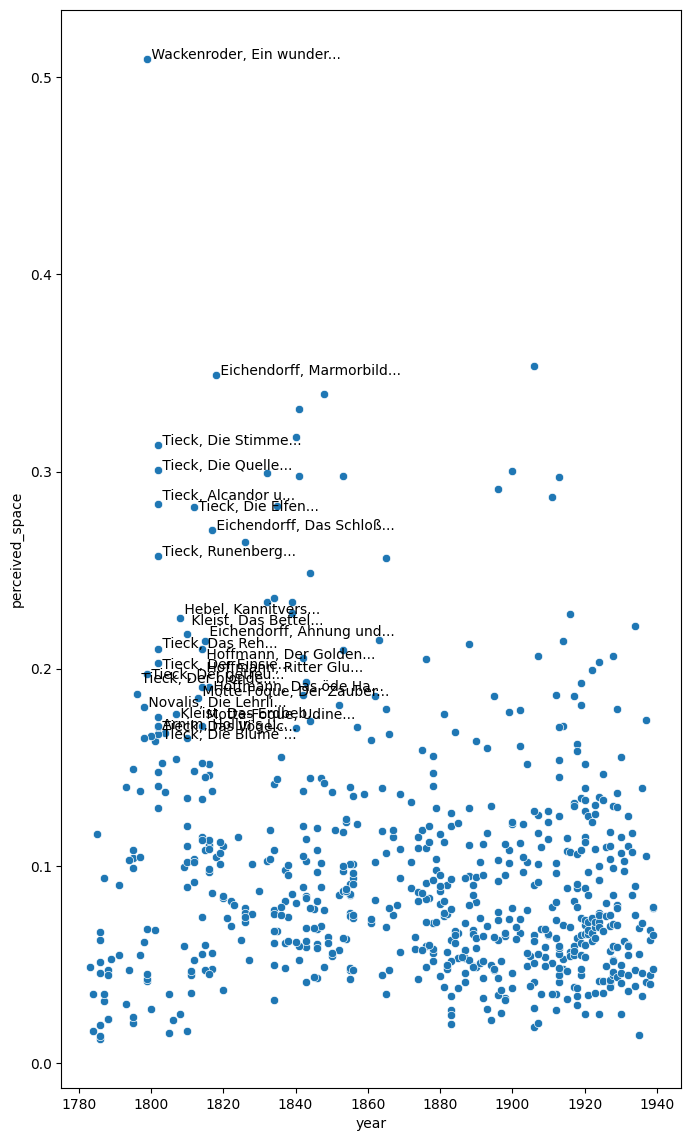

In [7]:
sns.set_style(rc = sns.axes_style())

color_indexer = {'action_space': 1,
 'perceived_space': 0,
 'visual_space': 2,
 'descriptive_space': 3,
 'all_space': 4}

palette = {space_type : sns.color_palette().as_hex()[i] for space_type, i in color_indexer.items()}

sel = (canon_df["year"] > 1780) 
plot_df2 = katspace.plot.calculate_ratios2(canon_df[sel], suffix = "")

plot_df2 = plot_df2.reset_index()

idxs = []

fig, ax = plt.subplots(figsize=(8, 14))

for space_type, cut_off, start_year, end_year in [#("action_space", 0.25, 1790, 1815)]:
                                                ("perceived_space", 0.17, 1790, 1820)]:
                                                    #("descriptive_space", 0.037, 1840, 1880)]
                                                #("visual_space", 0.040, 1790, 1960)]:
    
    
    ax = sns.scatterplot(ax = ax, x = plot_df2["year"], y = plot_df2[space_type], color = palette[space_type])

    #get indices of rows to annotate
    idx = (plot_df2[space_type] > cut_off) 
    idx = idx & (plot_df2["year"] >= start_year) & (plot_df2["year"] <= end_year)
    idxs.append(idx)
    
    ys = plot_df2.loc[idx].copy().sort_values(space_type, ignore_index = True)
    
    for i in range(100):  
        for j in range(len(ys) - 1):
            if (abs(ys.loc[j, space_type] - ys.loc[j+1, space_type]) < 0.005) & (abs(ys.loc[j, "year"] - ys.loc[j+1, "year"]) < 40): 
                step_size = 0.00095
                if ys.loc[j, space_type] < ys.loc[j+1, space_type]:
                    ys.loc[j, space_type] = ys.loc[j, space_type] - step_size
                    ys.loc[j+1, space_type] = ys.loc[j+1, space_type] + step_size
                else: 
                    ys.loc[j, space_type] = ys.loc[j, space_type] + step_size
                    ys.loc[j+1, space_type] = ys.loc[j+1, space_type] - step_size
            
    #loop over those rows to annotate
    for i,row in ys.iterrows():

        ax.text(s = " " + row["author_last"] + ", " + row["title"][:10] + "...", x = row["year"], y = row[space_type])

In [ ]:
df = plot_df2[idx]
df = df[plot_df2["visual_space"] < 0.30]
df

In [9]:
idx = plot_df2["action_space"] > 0.5 
idx = idx & (plot_df2["year"] >= 1810) & (plot_df2["year"] <= 1812)

#loop over those rows to annotate
for i,row in plot_df2.loc[idx].iterrows():
  ax.text(s = row["title"], x = row["year"], y = row["action_space"])
    

## Plot hist with and without outliers (Tieck, Stifter, Kleist)

Text(0.5, 0, 'Year')

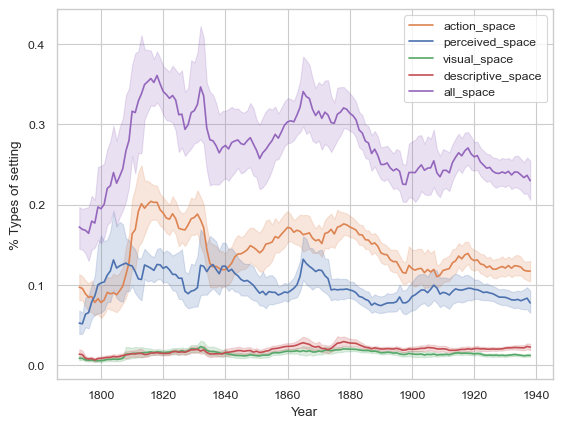

In [36]:
sel = (canon_df["year"] > 1780)
plot_df = katspace.plot.calculate_ratios2(canon_df[sel])

authors = ["Tieck", "Kleist", "Stifter"]
sel = (plot_df["author_last"].isin(authors))
plot_df = plot_df[~sel]

smooth_df = katspace.plot.smooth_df(plot_df[["action_space_rt", "perceived_space_rt", "visual_space_rt", "descriptive_space_rt", "all_space_rt"]])

sns.set_style("whitegrid")
sns.set_context("paper") 

lines = sns.lineplot(smooth_df, palette=["#dd8452", "#4c72b0", "#55a868", "#c44e52", "#9467bd"], dashes=False)
handles, labels = lines.get_legend_handles_labels()
custom_labels = ['action_space', 'perceived_space', 'visual_space', 'descriptive_space', 'all_space']


plt.legend(handles=handles[:5], labels=custom_labels)
plt.ylabel("% Types of setting")
plt.xlabel("Year")

Text(0.5, 0, 'Year')

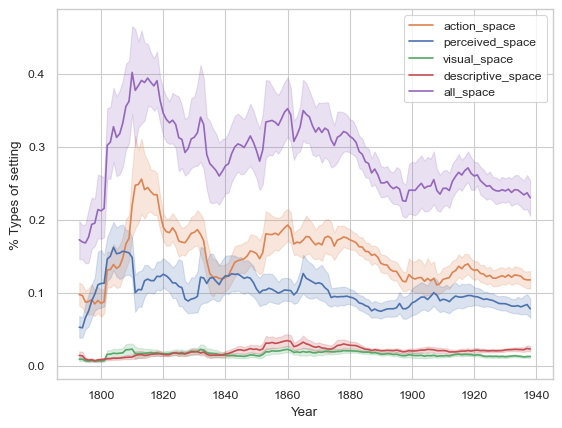

In [37]:
sel = (canon_df["year"] > 1780)
plot_df = katspace.plot.calculate_ratios(canon_df[sel])


smooth_df = katspace.plot.smooth_df(plot_df[["action_space_rt", "perceived_space_rt", "visual_space_rt", "descriptive_space_rt", "all_space_rt"]])

sns.set_style("whitegrid")
sns.set_context("paper") 

lines = sns.lineplot(smooth_df, palette=["#dd8452", "#4c72b0", "#55a868", "#c44e52", "#9467bd"], dashes=False)
handles, labels = lines.get_legend_handles_labels()
custom_labels = ['action_space', 'perceived_space', 'visual_space', 'descriptive_space', 'all_space']


plt.legend(handles=handles[:5], labels=custom_labels)
plt.ylabel("% Types of setting")
plt.xlabel("Year")


## Load results from json for plotting 

In [13]:
results = results_from_json(filenames)

In [ ]:
#ToDo: perhaps delete these empty files and figure out how to predict from these texts
for filename in results.keys():
  if results[filename] == None:
    print(filename)

In [10]:
#check if there are any nas

print(canon_df["total"].isna().any())
canon_df[canon_df["total"] == 0]

False


,author_last,author_first,title,filename,year,perceived_space,action_space,visual_space,descriptive_space,no_space,total,all_space,genre_3,period,gender
111,Fontane,Theodor,Die Poppenpuhls,Fontane_Theodor_Die-Poppenpuhls_1896,1896,0,0,0,0,0,0,0,NaN,NaN,NaN
218,Hunold,Christian Friedrich,Liebens-Würdigen Adalie,Hunold_Christian-Friedrich_Die-liebenswuerdige...,1702,0,0,0,0,0,0,0,NaN,NaN,NaN
222,Jacobi,Friedrich,Woldemar,Jacobi_Friedrich_Woldemar_1779,1779,0,0,0,0,0,0,0,NaN,NaN,NaN
320,Moerike,Eduard,Maler Nolten,Moerike_Eduard_Maler-Bolten_1836,1836,0,0,0,0,0,0,0,NaN,NaN,NaN
353,Paul,Jean,Auswahl aus des Teufels Papieren,Paul_Jean_Auswahl-aus-des-Teufels-Papieren_1789,1789,0,0,0,0,0,0,0,NaN,NaN,NaN
435,Schoenher,Karl,Allerhand Kreuzköpf. Geschichten und Gestalten...,Schoenherr_Karl_Allerhand-Krezkoepf_1895,1895,0,0,0,0,0,0,0,NaN,NaN,NaN
490,Tieck,Ludwig,Adbdallah,Tieck_Ludwig_Adbdallah_1792,1792,0,0,0,0,0,0,0,NaN,NaN,NaN
524,Wieland,Christoph Martin,Geschichte der Abderiten,Wieland_Christoph-Martin_Abderiten_1774,1774,0,0,0,0,0,0,0,NaN,NaN,NaN
669,Bahr,Hermann,Die Hexe Drut,Hermann_Bahr_-_Die_Hexe_Drut.txt,1929,0,0,0,0,0,0,0,"Romane, Novellen und Erzählungen",NaN,NaN


## Plot History

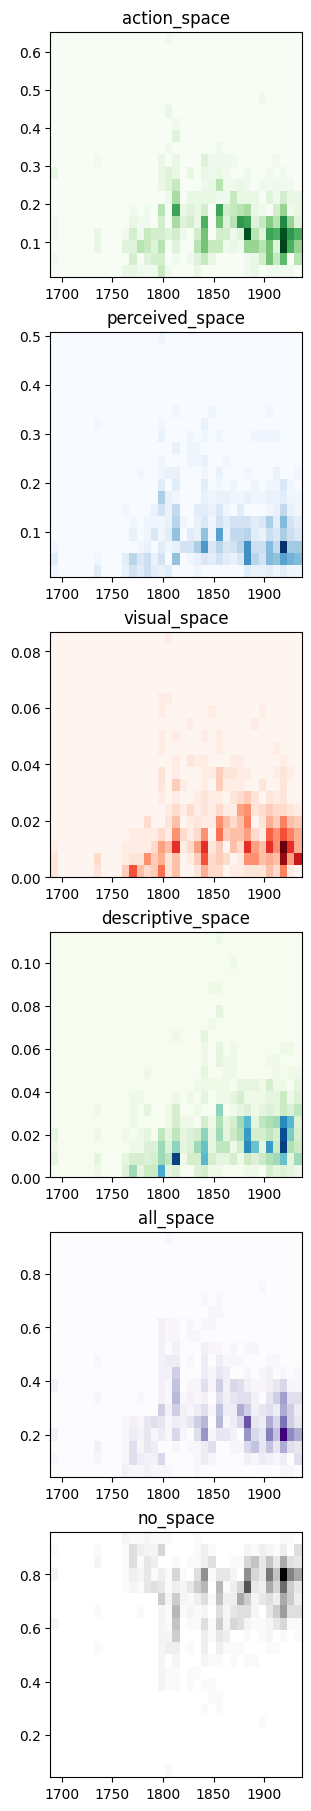

In [17]:
sel = (canon_df["year"] > 1770) & (canon_df["year"] < 1950)

plot_hist_heatmap(canon_df)

Text(0.5, 0, 'Year')

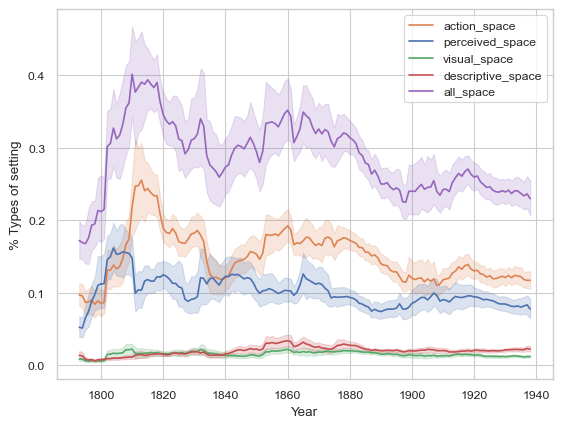

In [18]:
sel = (canon_df["year"] > 1780)
plot_df = katspace.plot.calculate_ratios(canon_df[sel])


smooth_df = katspace.plot.smooth_df(plot_df[["action_space_rt", "perceived_space_rt", "visual_space_rt", "descriptive_space_rt", "all_space_rt"]])

sns.set_style("whitegrid")
sns.set_context("paper") 

lines = sns.lineplot(smooth_df, palette=["#dd8452", "#4c72b0", "#55a868", "#c44e52", "#9467bd"], dashes=False)
handles, labels = lines.get_legend_handles_labels()
custom_labels = ['action_space', 'perceived_space', 'visual_space', 'descriptive_space', 'all_space']


plt.legend(handles=handles[:5], labels=custom_labels)
plt.ylabel("% Types of setting")
plt.xlabel("Year")

## Descriptives

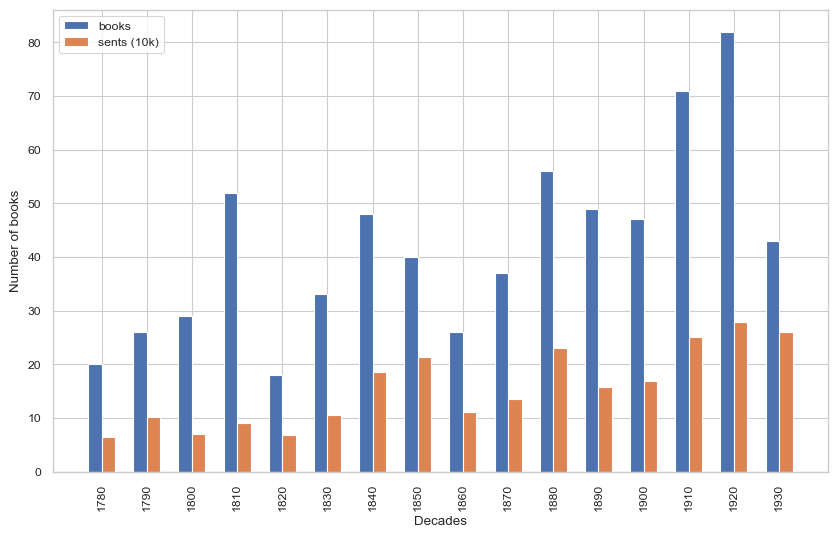

In [19]:
#df canon

sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper") 

df = canon_df.loc[:,["year", "total"]]
sel = (canon_df["year"] > 1780) & (canon_df["year"] < 1950)
df = df[sel]
df.loc[:,'books'] = 1 

def round_to_decade(y):
    return int(10 * math.floor(y / 10))

df["year"] = df["year"].apply(round_to_decade)

df_sums = df.groupby('year').sum()
df_sums["total"] = df_sums["total"] / 10000

df_sums.rename(columns = {"total" : "10k_sents", "year" : "decade"}, inplace = True)
years = df_sums.index.values

x = [xpos for xpos in range(len(years))]


fig, ax = plt.subplots(figsize=(10, 6))

width = 0.3


ax.bar([xpos - width/2 for xpos in x] , df_sums["books"], width, label="books")
ax.bar([xpos + width/2 for xpos in x], df_sums["10k_sents"], width, label="sents (10k)")
ax.set_xlabel("Decades")
ax.set_ylabel("Number of books")
ax.set_xticks(x, labels=years, rotation = 90)


ax.legend()